In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
#import matplotlib.pyplot as plt
import time
import os
import copy

In [ ]:
# TODO remove prints and unneccesary code

In [8]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        image_files = os.listdir(self.img_dir)        
        img_path = image_files[idx]
        image = read_image(os.path.join(self.img_dir, img_path)).float()
        label = int(img_path[-5])
        if self.transform:
            image = self.transform(image)
        return image, label

In [18]:
h, w = 100, 100

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((h,w)),
        #transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        #transforms.ToTensor(),
        #transforms.Normalize([133.2723, 114.6064, 107.2552], [74.0242, 71.1185, 71.7487])
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize((h,w)),
        #transforms.CenterCrop(224),
        #transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}


image_datasets = {x: CustomImageDataset(x, data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=64, shuffle=True) 
               for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = ["No Mask", "Has Mask"]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

(tensor([[[175.0000, 187.9200, 209.2000,  ..., 426.4001, 411.8400, 403.0000],
         [173.6400, 184.9416, 203.5560,  ..., 430.7520, 417.7151, 409.8000],
         [171.4000, 180.0360, 194.2600,  ..., 437.9200, 427.3920, 421.0000],
         ...,
         [436.8000, 437.1400, 437.7000,  ..., 428.0999, 436.5000, 441.6000],
         [435.6800, 437.9240, 441.6200,  ..., 436.5000, 441.7640, 444.9600],
         [435.0000, 438.4000, 444.0000,  ..., 441.6000, 444.9600, 447.0000]],

        [[241.0000, 247.1200, 257.2000,  ..., 304.4000, 289.8400, 281.0000],
         [240.3200, 245.2840, 253.4600,  ..., 308.7520, 295.7152, 287.8000],
         [239.2000, 242.2600, 247.3000,  ..., 315.9200, 305.3920, 299.0000],
         ...,
         [102.8000, 101.7800, 100.1000,  ..., 100.9400, 107.3240, 111.2000],
         [101.6800, 102.5640, 104.0200,  ..., 105.0840, 109.5864, 112.3200],
         [101.0000, 103.0400, 106.4000,  ..., 107.6000, 110.9600, 113.0000]],

        [[331.0000, 329.6400, 327.4000,  ..

In [69]:
"""def imshow(inp, title=None):
    Imshow for Tensor
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([133.2723, 114.6064, 107.2552])
    std = np.array([74.0242, 71.1185, 71.7487])
    inp = std * inp + mean
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[int(x)] for x in classes])"""

## Architecture

In [20]:
class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1, identity=None):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1)
        self.identity = identity
        
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
            
        if self.identity is not None:
            identity = self.identity(x)
        out += identity # output = F(x) + I(x) Where F() is the convultion sandwitch and I() is the identity func
        out = self.relu(out)
        return out

class ResNetCreator(nn.Module):
    
    def __init__(self, block, layers, num_classes=2, width_param=64):
        super(ResNetCreator, self).__init__()
        self.in_channels = width_param
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=3, stride=1, padding=3)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU()
        
        self.layer1 = self.make_layer(block, width_param, layers[0], stride=1)
        self.layer2 = self.make_layer(block, 2*width_param, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 4*width_param, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 8*width_param, layers[3], stride=2)
        
        self.avgpool = nn.AvgPool2d(4)
        #self.fc = nn.Linear(8*width_param*block.expansion, num_classes)
        self.fc = nn.Linear(4608, num_classes)
        
    def make_layer(self, block, out_channels, num_layers, stride):
        identity = None
        
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            identity = nn.Sequential(nn.Conv2d(self.in_channels, out_channels, 1, stride),
                                    nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, identity))
        
        self.in_channels = out_channels
        for i in range(1,num_layers):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    
def ResNet18(k=64, num_classes=2):
    """
    Our ResNet18 Creator.
    Where k is the width parameter of convolutional layers
    and num_classes is the number of classes (in CIFAR 10 this number is 10)
    """
    return ResNetCreator(Block, [2, 2, 2, 2], num_classes, k)

c= torch.rand(64,3,100,100)
d= ResNet18()
res = d(c)
print(res.shape)

torch.Size([64, 2])


In [5]:
def train_test(model, num_epochs, train_dataset, train_loader, criterion, optimizer, test_dataset ,test_loader):
    train_losses = []
    test_losses = []

    train_f1 = []
    test_f1 = []
    
    for epoch in range(num_epochs):
    
    
        agg_train_loss = 0
        agg_test_loss = 0

        TP_train, FP_train, FN_train, TN_train = 0, 0, 0, 0
        TP_test, FP_test, FN_test, TN_test = 0, 0, 0, 0

      # Training
        model.train(True)
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            #images = images.view(images.shape[0], -1)

            # Forward + Backward + Optimize
            model.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            

            agg_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            ones = torch.ones(len(predicted)).to(device)
            zeroes = torch.zeros(len(predicted)).to(device)
            TP_train += ((predicted == labels)&(predicted == ones)).sum().item()
            TN_train += ((predicted == labels)&(predicted == zeroes)).sum().item()
            FP_train += ((predicted != labels)&(predicted == ones)).sum().item()
            FN_train += ((predicted != labels)&(predicted == zeroes)).sum().item()
            
    
            #optimizer.zero_step()
            loss.backward()
            optimizer.step()
  
        train_losses.append(agg_train_loss / len(train_loader))
        f1_train_value = 2 * TP_train / (2 * TP_train + FP_train + FN_train)
        train_f1.append(f1_train_value)

        # Testing
        model.train(False)
        with torch.no_grad():
            for i, (images, labels) in enumerate(test_loader):
                images = images.to(device)
                labels = labels.to(device)

                #images = images.view(images.shape[0], -1)

                # Forward only
                outputs = model(images)
                loss = criterion(outputs, labels)

                agg_test_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                ones = torch.ones(len(predicted)).to(device)
                zeroes = torch.zeros(len(predicted)).to(device)
                TP_test += ((predicted == labels)&(predicted == ones)).sum().item()
                TN_test += ((predicted == labels)&(predicted == zeroes)).sum().item()
                FP_test += ((predicted != labels)&(predicted == ones)).sum().item()
                FN_test += ((predicted != labels)&(predicted == zeroes)).sum().item()
  
        test_losses.append(agg_test_loss / len(test_loader))
        f1_test_value = 2 * TP_test / (2 * TP_test + FP_test + FN_test)
        test_f1.append(f1_test_value)
  
        if epoch % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train loss: {train_losses[-1]:.2f}, F1. {train_f1[-1]:.2f}; Test loss: {test_losses[-1]:.2f}, F1. {test_f1[-1]:.2f}')
    return [train_losses, test_losses, train_f1, test_f1]

In [91]:
#import matplotlib.pyplot as plt
import json
criterion = nn.CrossEntropyLoss()
resnet18 = ResNet18(64, num_classes=2)
resnet18.to(device)
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.0001, weight_decay=0.0005)
list_resnet = train_test(resnet18, 500, image_datasets["train"], dataloaders["train"], criterion, optimizer, image_datasets["test"], dataloaders["test"])
dict_resnet = {"train_losses": list_resnet[0], "test_losses": list_resnet[1], "train_f1": list_resnet[2],
              "test_f1": list_resnet[3]}
with open('data.json', 'w') as fp:
    json.dump(dict_resnet, fp)

torch.Size([4, 512, 5, 5])
torch.Size([4, 12800])
torch.Size([4, 2])
torch.Size([4, 512, 5, 5])
torch.Size([4, 12800])
torch.Size([4, 2])
torch.Size([4, 512, 5, 5])
torch.Size([4, 12800])
torch.Size([4, 2])


KeyboardInterrupt: 

In [ ]:
torch.save(resnet18.state_dict(), 'Resnet18_Adam(0.0001, 0.0005),k=64,CrossEntropy.pkl')
# TODO save list_resnet

In [21]:
model2 = ResNet18()
model2.load_state_dict(torch.load("Resnet18_Adam(0.0001, 0.0005),k=64,CrossEntropy,epoch=0.pkl",
                                 map_location=torch.device('cpu')))

<All keys matched successfully>

In [5]:
import json
import matplotlib.pyplot as plt

with open("data2.json") as file:
    data2 = json.load(file)
train_losses = data2["train_losses"]
test_losses = data2["test_losses"]
train_f1 = data2["train_f1"]
test_f1 = data2["test_f1"]
test_f1[30]

0.980909090909091

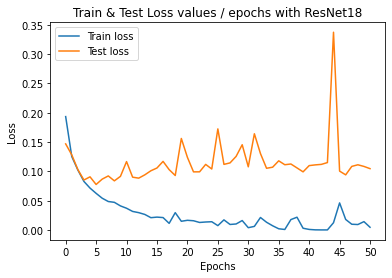

In [38]:
plt.plot(train_losses, label='Train loss')
plt.plot(test_losses, label='Test loss')
plt.title('Train & Test Loss values / epochs with ResNet18')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.xticks(list(range(0, 51, 5)))
plt.show()

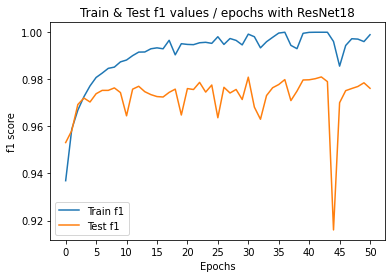

In [39]:
plt.plot(train_f1, label='Train f1')
plt.plot(test_f1, label='Test f1')
plt.title('Train & Test f1 values / epochs with ResNet18')
plt.ylabel('f1 score')
plt.xlabel('Epochs')
plt.legend()
plt.xticks(list(range(0,51, 5)))
plt.show()

In [ ]:
y_test = []
probas = []
softmax = nn.Softmax()

model.train(False)
with torch.no_grad():
    for i, (images, labels) in enumerate(dataloader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        y_test.append(labels.item())
        p = softmax(outputs.data)[:, 1]
        probas.append(p)

    fpr, tpr, _ = metrics.roc_curve(y_test, probas)
    auc = metrics.roc_auc_score(y_test, probas)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.plot([0, 1], [0, 1], color="orange", lw=2, linestyle="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("Train ROC")
plt.legend(loc=4)
plt.show()